At some point, as someone who has worked in online travel business who has just launched a new feature which enable users to rent cars, you began to wonder: 

<center><b>How is our renting car product going?</b></center>

As a product manager, you have a background as a computer scientist, which enables you to code but unfortunately does not have same level of understanding as a statistician to answer this question. Currently this product has run for 20 days. So how do we answer our question? What does it mean for your car renting to be good or bad?

Of course: sales! We can totally measure **how many reservations each day do our users make?**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(19)
ndays = 20
days = list(range(1, ndays + 1))
reservations = list(np.random.randint(100, size=20))
data = pd.DataFrame({
    'day': days,
    'n_reservations': reservations
})

data.head()

,day,n_reservations
0,1,93
1,2,98
2,3,40
3,4,19
4,5,52


We have loaded our data, now let's visualize it to get a clearer picture of our progress after launch!

One statistics metrics that popped out of our mind is: **Mean / Average**

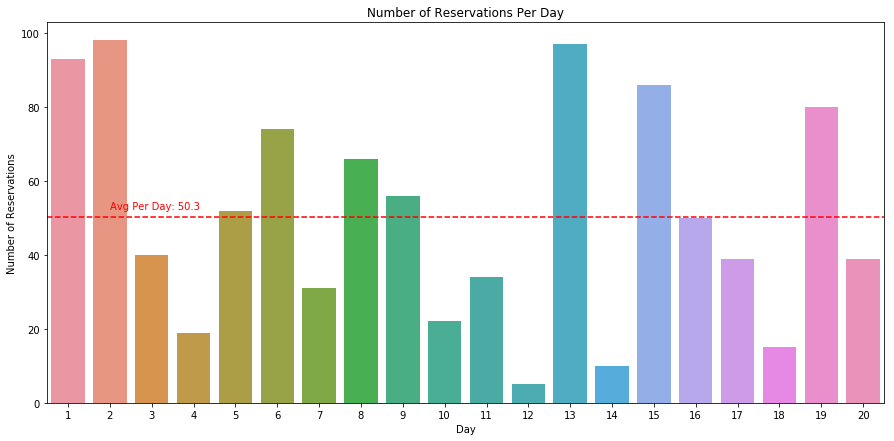

In [3]:
avg_per_day = data.n_reservations.mean()

f, ax = plt.subplots(figsize=(15, 7))
plt.title('Number of Reservations Per Day')
sns.barplot(
    x='day',
    y='n_reservations',
    data=data,
    ax=ax
)
plt.axhline(avg_per_day, color='red', linestyle='--')
plt.annotate(
    'Avg Per Day: {}'.format(avg_per_day),
    (1, avg_per_day + 2),
    color='red'
)
plt.xlabel('Day')
plt.ylabel('Number of Reservations')

plt.show()

Now we know that our product is capable to rent about 50 cars per day. You want to forecast 30 days ahead on how much in total your newly born product would contribute to the business in total.

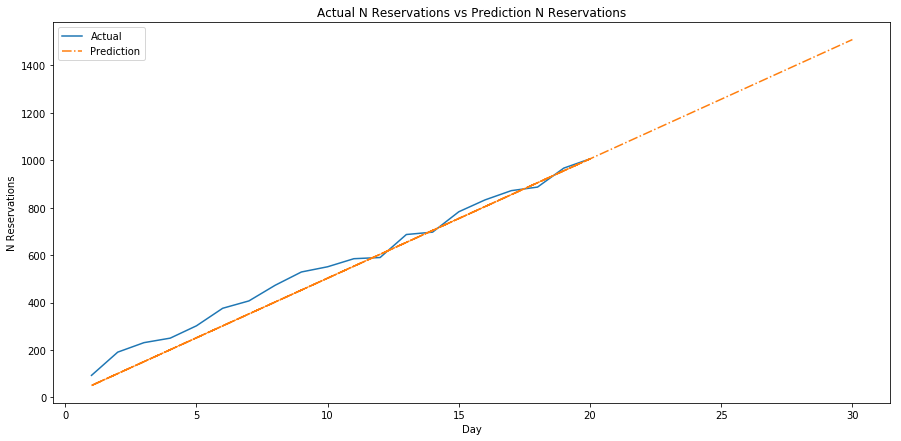

In [4]:
data['n_reservations_cumsum'] = data.n_reservations.cumsum()
day_actual_and_prediction = list(data.day) + [i for i in range(1, 31)]
prediction = np.array(day_actual_and_prediction) * avg_per_day
f, ax = plt.subplots(figsize=(15, 7))

plt.title('Actual N Reservations vs Prediction N Reservations')

sns.lineplot(
    x='day',
    y='n_reservations_cumsum',
    data=data,
    label='Actual'
)

plt.plot(
    day_actual_and_prediction,
    prediction,
    linestyle='-.',
    label='Prediction'
)
plt.ylabel('N Reservations')
plt.xlabel('Day')
plt.legend()
plt.show()

However, as we see in our visualization, we do not always rent 50 cars per day. Sometimes we have about 10 reservations, sometimes maybe 90. 

So how do you capture the **uncertainty**? Especially, you want to make sure that your projection will include worst case scenario and best case scenario.

# Calculating Uncertainty: Bootstrap Resampling

## Idea

Simulate distribution by drawing samples with replacement.

## Motivation

We draw random samples from our current data.

In [5]:
def draw_random_samples(reservations_distributions, sample_size):
    return np.random.choice(data.n_reservations, size=sample_size)

In [6]:
n_repetition = 10000 
xbars = list()

for i in range(n_repetition):
    xbars.append(np.mean(draw_random_samples(data.n_reservations, 20)))
    
    
mean, std = np.mean(xbars), np.std(xbars)

print('Result: mean: {:.2f}, std: {:.2f}'.format(mean, std))

Result: mean: 50.26, std: 6.49


At this stage, you might wonder,
> "Why dont' we take the mean and standard deviation directly from 20 data that we have?"

Well.. how certain are you?

In [7]:
from scipy.stats import norm

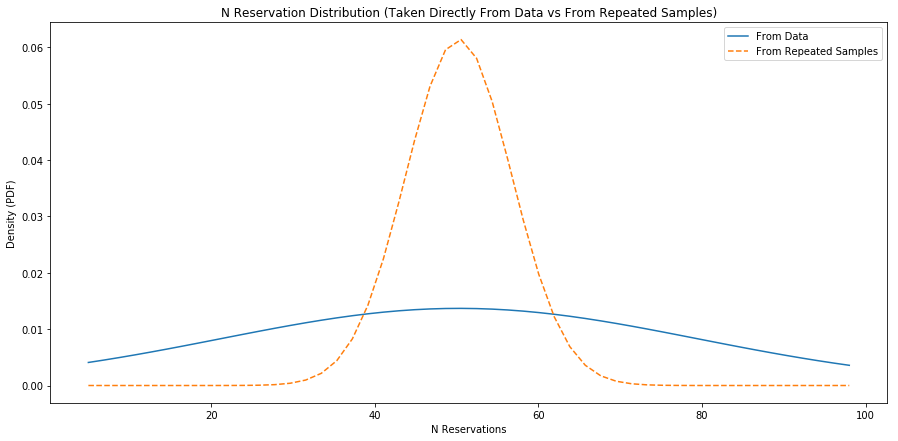

In [8]:
mean_data, std_data = np.mean(data.n_reservations), np.std(data.n_reservations)
mean_repeated_samples, std_repeated_samples = mean, std

x = np.linspace(np.min(data.n_reservations), np.max(data.n_reservations))
y_data = norm.pdf(x, loc=mean_data, scale=std_data)
y_repeated_sample = norm.pdf(x, loc=mean_repeated_samples, scale=std_repeated_samples)

f, ax = plt.subplots(figsize=(15, 7))
plt.plot(x, y_data, label='From Data')
plt.plot(x, y_repeated_sample, label='From Repeated Samples', linestyle='--')
plt.xlabel('N Reservations')
plt.ylabel('Density (PDF)')
plt.title('N Reservation Distribution (Taken Directly From Data vs From Repeated Samples)')
plt.legend()
plt.show()

Density from the data looks wider and with lower PDF, this means that if we take the statistics directly from the data, we could get something from average and standard deviation but we are not sure enough.

Repeated sampling / Bootstrap sampling, on the other hand, shows a sharper and narrower curve, which means that we are more confident about this average.

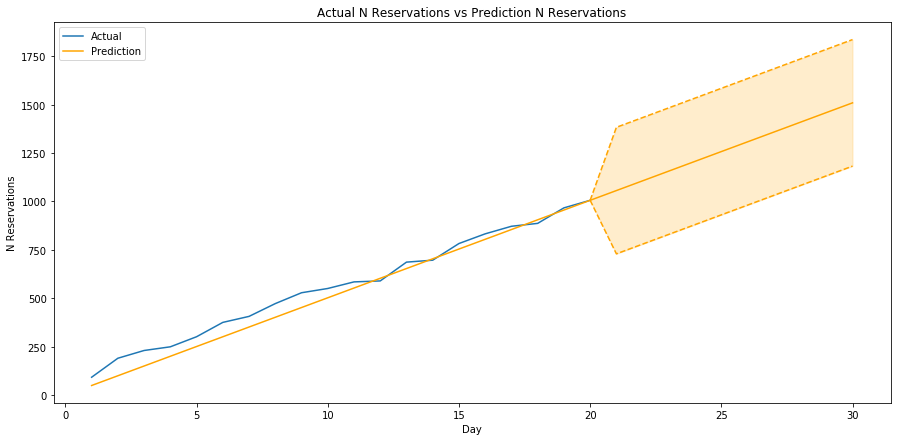

In [9]:
day_prediction = [i for i in range(data.day.max() + 1, 31)]
day_actual_and_prediction = list(data.day) + day_prediction
prediction = np.array(day_actual_and_prediction) * avg_per_day
lower_bound = (np.array(day_prediction) - std) * avg_per_day
upper_bound = (np.array(day_prediction) + std) * avg_per_day

f, ax = plt.subplots(figsize=(15, 7))

plt.title('Actual N Reservations vs Prediction N Reservations')

sns.lineplot(
    x='day',
    y='n_reservations_cumsum',
    data=data,
    label='Actual'
)

plt.plot(
    day_actual_and_prediction,
    prediction,
    color='orange',
    label='Prediction'
)
plt.plot(
    [data.day.max()] + day_prediction,
    [data.day.max() * avg_per_day] + list(lower_bound),
    color='orange',
    linestyle='--'
)
plt.plot(
    [data.day.max()] + day_prediction,
    [data.day.max() * avg_per_day] + list(upper_bound),
    color='orange',
    linestyle='--'
)
plt.fill_between(
    [data.day.max()] + day_prediction,
    [data.day.max() * avg_per_day] + list(lower_bound),
    [data.day.max() * avg_per_day] + list(upper_bound),
    color='orange',
    alpha=0.2
)

plt.ylabel('N Reservations')
plt.xlabel('Day')
plt.legend()
plt.show()

In [10]:
d = 30
print(
    'On day-{}, we would have an average of {:,.0f} cumulative reservations, with interval between {:,.0f} - {:,.0f} '.format(
        d,
        d * avg_per_day,
        (d - std) * avg_per_day,
        (d + std) * avg_per_day
    )
)

On day-30, we would have an average of 1,509 cumulative reservations, with interval between 1,183 - 1,835 


# Calculating Uncertainty: Statistician Way Using t-distribution

## Idea
Assuming that we have normal distribution with known mean, but unknown standard deviation. We could **normalize** our standard deviation by the observed data.

## Motivation
We have small sample, we are unsure how will our data deviates given this small sample.

$$
SE = s = \frac{1}{\sqrt{n}} \sqrt {\frac{\sum^n_{i=1}{x_i - \mu}}{n - 1}} = \frac{\sigma}{\sqrt{n}}
$$

where:
- $n$ is sample size
- $SE$ is standard error
- $s$ is normalized standard deviation / t-distribution's standard deviation
- $\sigma$ is standard deviation from gaussian distribution


with a statistician mindset, we can directly compute the sample standard deviation using this formula to get approximately the same result to our bootstrap sampling method.

In [12]:
std_t = np.std(data.n_reservations) / np.sqrt(data.shape[0])
assert np.isclose(std, std_t, atol=0.05)

print(
    'Std from bootstrap resampling: {:.2f} is close with sample std: {:.2f}'.format(
        std,
        std_t
    )
)

Std from bootstrap resampling: 6.49 is close with sample std: 6.52


# References

[1] [Student's t-distribution: Wikipedia](https://en.wikipedia.org/wiki/Student%27s_t-distribution)

[2] [Standard Error: Wikipedia](https://en.wikipedia.org/wiki/Standard_error)